In [ ]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]
!pip install imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379372 sha256=ab0afd9286e2baf03c4a1495e92782a61982901a38a661c920bf2db4bcfc72b4
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


### Environment - Lundar Lander v3 OpenAI Gym

The Lunar Lander environment can be found here: -

The cell below gives random action endpoints in the Lunar Lander environment and their visualisation.

The environment a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.
The following constitutes action space of the agent:

*   0: do nothing
*   1: fire left orientation engine
*   2: fire main orientation engine
*   3: fire right orientation engine

and the following constitutes of state space of the agent:

*   Coordinates of lander in x & y
*   linear velocities in x & y
*   angle
*   Angular Velocity
*   Two booleans that specify whether each leg has landed or not

Rewards For agent:
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

* is increased/decreased the closer/further the lander is to the landing pad.

* is increased/decreased the slower/faster the lander is moving.

* is decreased the more the lander is tilted (angle not horizontal).

* is increased by 10 points for each leg that is in contact with the ground.

* is decreased by 0.03 points each frame a side engine is firing.

* is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered solution when it crosses above 200 points.


An Episode is finished if:
* Lander crashes
* Lander gets outside of the viewport
* Lander is still

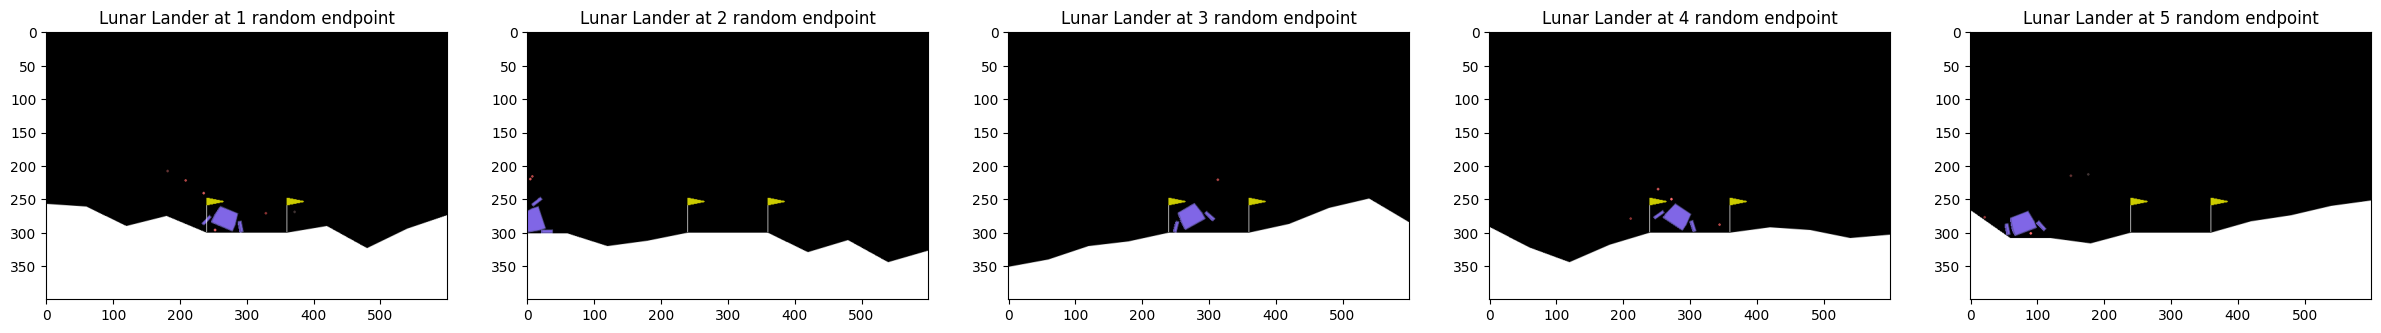

In [ ]:
import gymnasium as gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import base64, io
import os

from collections import deque, namedtuple
import imageio
from IPython import display
from IPython.display import Image


env = gym.make("LunarLander-v3", render_mode='rgb_array')
i = 0
fig, ax = plt.subplots(1, 5, figsize=(30, 30))

while i <= 4:
  observation = env.reset()

  while True:
    # plot a random point
    ax[i].imshow(env.render())
    ax[i].set_title(f'Lunar Lander at {i+1} random endpoint')

    act = env.action_space.sample()
    # print("Act", act)

    observation, reward, terminated, truncated, info = env.step(act)
    # print("Observation", observation)

    if terminated or truncated:
      break

  # env.close()
  # plt.show()
  i += 1

env.close()
plt.show()

In [ ]:
import math
import random
import matplotlib
import matplotlib.pyplot as ply
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("LunarLander-v3", render_mode='rgb_array')
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


###Class DQN
DQN is a neural network with 3 fully connected layers with input layer(`state_size`×128) and hidden layer (128×128) activated by ReLU, and output layer(128×`action_size`).

In [ ]:
class DQN(nn.Module):
  """ Q-value network """

  def __init__(self, state_size, action_size):
    super(DQN, self).__init__()
    self.l1 = nn.Linear(state_size, 128)
    self.l2 = nn.Linear(128, 128)
    self.l3 = nn.Linear(128, action_size)

  def forward(self, x):
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    return self.l3(x)

# Class Agent
### Hyperparameters
* `BUFFER_SIZE`:
* `BATCH_SIZE`: number of frames taken into observation
* `GAMMA`:
* `EPS_START`: Epsilon value at the start of training
* `EPS_END`: Epsilon value at the end of training
* `EPS_DECAY`: value of decay in value of epsilon during the training
* `TAU`: Soft update parameter
* `LR`: Learning rate of optimizer

### Parameters
* `state_size` and `action_size`: `state_size` and `action_size` of the environment are defined.
* `optimizer`: Adam optimizer for backward pass for policyNet
* `tau`: soft update parameter for stable updates of targetNet
* `memory`: Replay Memory class
* `seed`: random seed for sampling experiencces from replay memory
* `policyNet`: Neural network of class `DQN`, responsible for action selection and approximating Q-values,  
* `targetNet`: Neural network of class `DQN`, calculates the Q-values with help of `rewards` and `next_states`

### `act(state, eps=0)`
Function takes in `states` and model evaluation of `policyNet` for the particular state tensor. After the forward pass of `policyNet` DQN, we have action values from policyNet. Here, we have epsilon greedy method to pick action depending on chance.

### `learn(exp, gamma)`:
From the experience tuple, we have `states`, `actions`, `rewards`, `next_state` and `dones`.
We use `next_state` to get the action values for next possible states from `targetNet`. The target action values `q_target` is given by the equation as follows:
<center>$ Q(s, a) ← r + γ×Q(s`, a`)×(1 - dones) $</center>
where,

* $ Q(s, a) $ is expected action values `q_expected`
* $ \gamma $ is discount rate
* $ Q(s`, a`) $ is the action values from `targetNet` `DQN` for `next_states` input. `q_target`

loss calculation: The mean squared error loss between `q_expected` and `q_target`. After initializing gradients of the tensor, backpropogation of loss to get new gradients and it updates the network weights using optimzier. Finally, the `targetNet` is softly updated towards `policyNet` to track its weights, improving stability during training.

### `soft_update(policyNet, targetNet)`:
the `targetNet` parameters are changed by the following equation:
<center>$Θ_{targetNet} ← Θ_{policyNet}×τ+Θ_{targetNet}×(1-τ)$</center>
where,

* $Θ_{targetNet}$: parameters of `targetNet`
* $Θ_{policyNet}$: parameters of `policyNet`
* τ: soft update parameter

In [ ]:
#HYPERPARAMETERS
BUFFER_SIZE=10000
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.995
TAU = 0.005
LR = 1e-4

class Agent():
  """
  Agent() class has policyNet, targetNet and optimizer
  """
  def __init__(self, state_size, action_size, seed):
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.policyNet = DQN(state_size, action_size).to(device)
    self.targetNet = DQN(state_size, action_size).to(device)
    self.optimizer = optim.Adam(self.policyNet.parameters(), lr=LR)
    self.tau = TAU

    self.memory = ReplayMem(action_size, BUFFER_SIZE, BATCH_SIZE, self.seed)

  def select_act(self, state, eps=0):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.policyNet.eval()
    with torch.no_grad():
      action_values = self.policyNet(state)
    self.policyNet.train()

    if random.random() > eps:
      return torch.argmax(action_values).item()
    else:
      return random.randint(0, self.action_size - 1)

  def learning(self, exp, gamma):
    states, actions, rewards, next_states, dones = exp
    q_next = self.targetNet(next_states).detach().max(1)[0].unsqueeze(1)
    q_target= rewards + gamma * q_next * (1 - dones)
    q_expected = self.policyNet(states).gather(1, actions)

    loss = F.mse_loss(q_expected, q_target)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.policyNet, self.targetNet)
    return loss.item()

  def soft_update(self, policyNet, targetNet):
    for target_param, local_param in zip(targetNet.parameters(), policyNet.parameters()):
      target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


## class ReplayMem

### Parameters

* `action_size`: action size of the environment
* `batch_size`: used for sampling
* `seed`: random seeding for sampling experiences
* `buffer_size`: maximum length of the deque
* `memory`: deque of `experience` tuples
* `experience`: named tuple with field names as `state`, `action`, `reward`, `next_state`, `done`

### `push(state, action, reward, next_state, done)`
Add `experience` tuple is added to the memory deque after extracting the arguments.

### `sample()`
Taking a random sample from the memory deque of size `batch_size` and extracting `states`, `actions`, `rewards`, `next_states`, `dones` as a tuple.

### `__len__()`:
Length of memory deque.

In [ ]:
class ReplayMem():
  def __init__(self, action_size, buffer_size, batch_size, seed):
    self.action_size = action_size
    self.batch_size = batch_size
    self.seed = random.seed(seed)
    self.memory = deque(maxlen=buffer_size)
    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

  def push(self, state, action, reward, next_state, done):
    e = self.experience(state, action, reward, next_state, done)
    self.memory.append(e)

  def sample(self):
    experiences = random.sample(self.memory, k = self.batch_size)

    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.float32)).float().to(device)

    return (states, actions, rewards, next_states, dones)

  def __len__(self):
    return len(self.memory)

## Training dqn
`dqn(n_eps=1000, max_t=500, agent=Agent(state_size=8, action_size=4, seed=0))`:
Tracking `rewards`, `training_loss` and `success_eps` from episode 1 to 1000 and maximum steps per episode is 500.

At the start of each episode, reset the environment and at each state, let the agent perform an action by `agent.select_act(state, eps)`, which is defined as an epsilon greedy method.
For the particular `action`, extract `next_state`, `reward`, `terminated`, `truncated` and define `done`=`terminated` or `truncated`. Use `agent.memory` to `push` the `state`, `action`, `reward`, `next_state`, `done` as arguments.

if the `agent.memory` stack length exceeds the `BATCH_SIZE`, Sample experiences `exp` from `agent.memory.sample()` and track loss by calling `agent.learn`.

if in the turn, parameter `done` is `True`, you can exit the loop and end the episode.

Save model weights for `policyNet` of `agent`.

In [ ]:
def dqn(n_eps=1000, max_t=500, agent=Agent(state_size=8, action_size=4, seed=0)):
  rewards = []
  rewards_window = deque(maxlen=BATCH_SIZE)
  training_loss = []
  eps = EPS_START
  success_eps = []

  for ieps in range(1, n_eps + 1):
    state, _ = env.reset()
    state = np.array(state)
    ep_reward, loss = 0, 0
    episode_losses = []

    for t in range(max_t):
      action = agent.select_act(state, eps)
      next_state, reward, terminated, truncated, _ = env.step(action)
      next_state = np.array(next_state)
      done = terminated or truncated

      agent.memory.push(state, action, reward, next_state, done)

      if len(agent.memory) > BATCH_SIZE:
        exp = agent.memory.sample()
        loss = agent.learning(exp, GAMMA)
        episode_losses.append(loss)

      state = next_state
      ep_reward += reward
      if done:
        break
    if (ep_reward) >= 200.0:
      success_eps.append(ieps)
    rewards_window.append(ep_reward)
    rewards.append(ep_reward)
    if episode_losses:
      training_loss.append(np.mean(episode_losses))
    eps = max(EPS_END, EPS_DECAY * eps)
    if ieps % 100 == 0:
      print(f'Episode {ieps}\t Average Rewards: {np.mean(rewards_window):.2f}\t Average Loss: {np.mean(training_loss[-100:]):.4f}\t Epsilon: {eps:.3f}')
  torch.save(agent.policyNet.state_dict(), 'checkpoint.pth')
  return rewards, training_loss, success_eps

### plot_rewards(rewards, training_loss)
plotting two separate graphs, `rewards`, `training_loss` and `success_eps` of the Agent

In [ ]:
def plot_rewards(rewards, training_loss, success_eps):
  plt.figure(figsize=(10, 6))
  plt.plot(rewards, 'b-')
  plt.title('Lunar Lander DRL Agent Reward')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(10, 6))
  plt.plot(training_loss, 'r-')
  plt.title('Training Loss for Lunar Lander DRL Agent')
  plt.xlabel('Episode')
  plt.ylabel('Loss')
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(10, 6))
  plt.scatter(success_eps, [rewards[i - 1] for i in success_eps])
  plt.title('Successful episodes')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0)
rewards, training_loss, success_eps = dqn()

Episode 100	 Average Rewards: -144.25	 Average Loss: 53.4577	 Epsilon: 0.606
Episode 200	 Average Rewards: -50.15	 Average Loss: 15.9811	 Epsilon: 0.367
Episode 300	 Average Rewards: 45.46	 Average Loss: 6.8099	 Epsilon: 0.222
Episode 400	 Average Rewards: 135.08	 Average Loss: 9.2004	 Epsilon: 0.135
Episode 500	 Average Rewards: 214.82	 Average Loss: 9.5564	 Epsilon: 0.082
Episode 600	 Average Rewards: 230.98	 Average Loss: 8.6140	 Epsilon: 0.049
Episode 700	 Average Rewards: 243.69	 Average Loss: 6.4959	 Epsilon: 0.030
Episode 800	 Average Rewards: 236.26	 Average Loss: 7.2041	 Epsilon: 0.018
Episode 900	 Average Rewards: 254.43	 Average Loss: 3.9015	 Epsilon: 0.011
Episode 1000	 Average Rewards: 259.54	 Average Loss: 5.4917	 Epsilon: 0.010


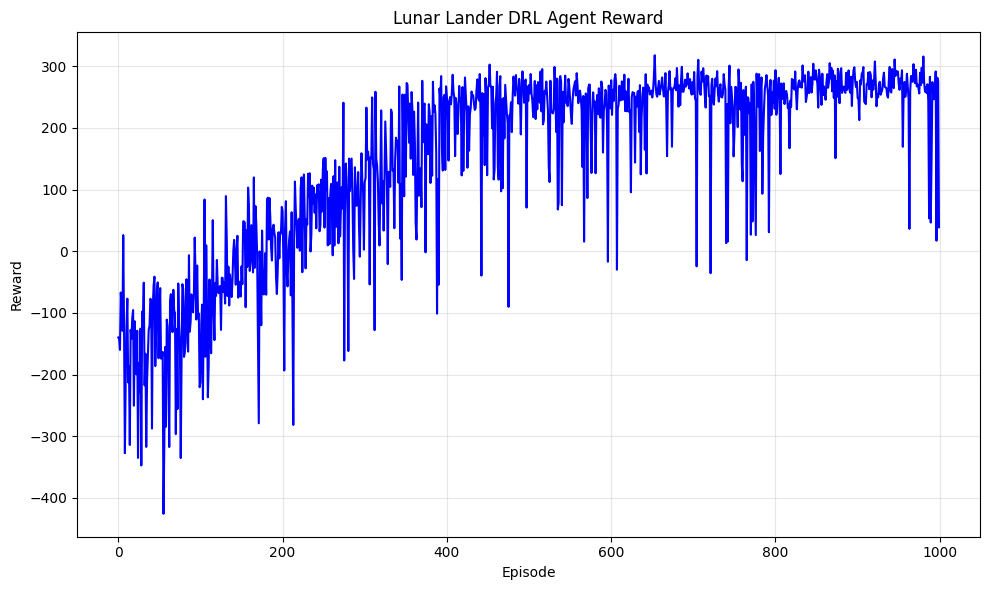

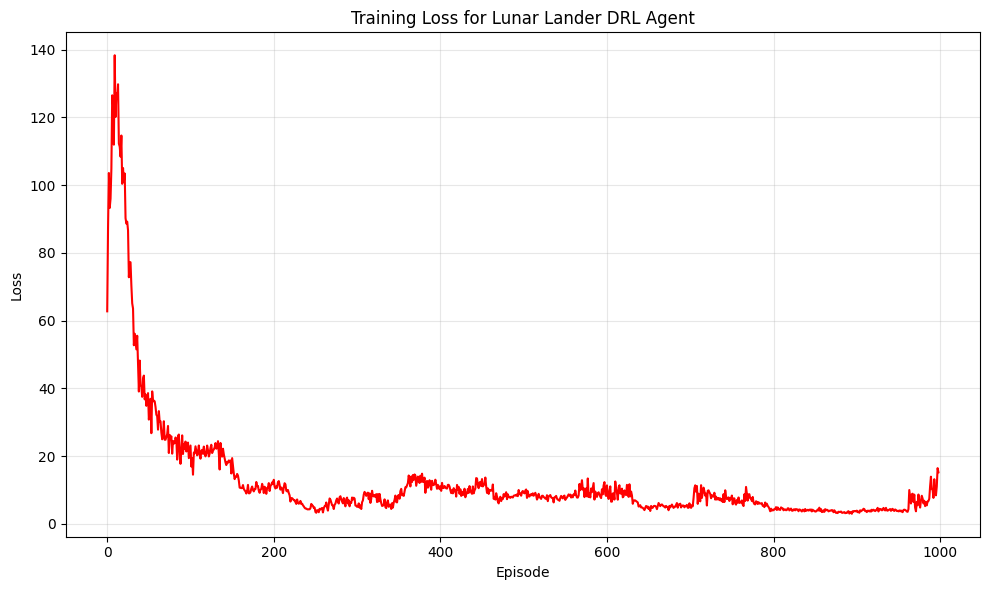

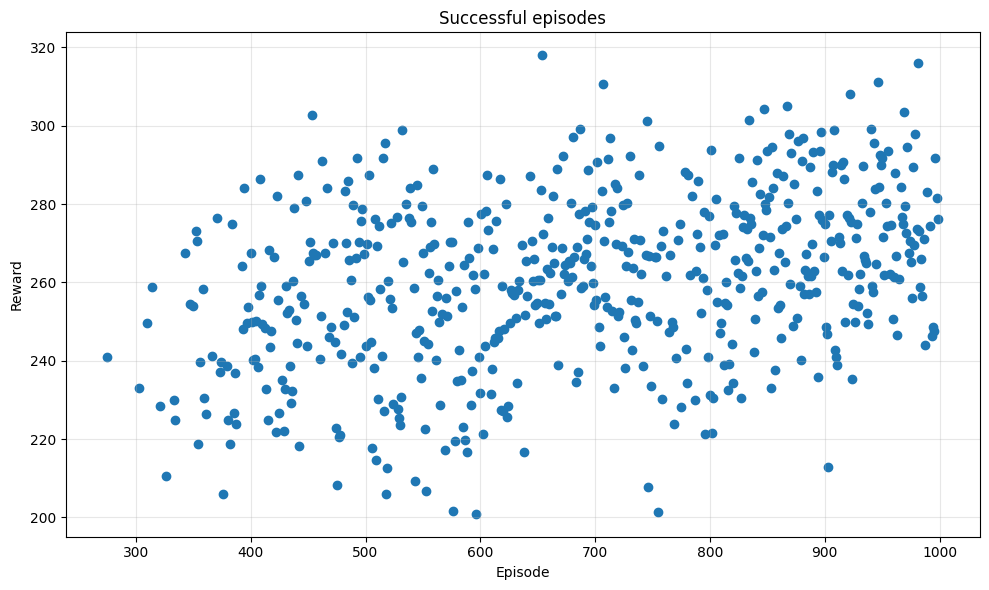

In [ ]:
plot_rewards(rewards, training_loss, success_eps)

### record_gif_of_agent
make environment and load the agent's `policyNet` parameters from saved and evaluate. While the episode is running `done=True` and number of steps taken are less than maximum number of steps `num_steps`, render the images and let agent select action based on current state. Use imageio.mimsave to save the gif with `duration=50`


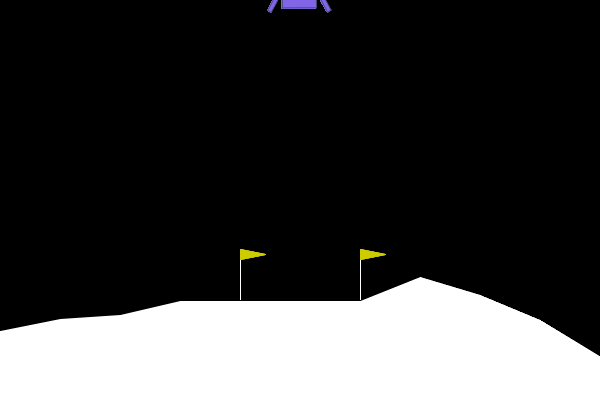

In [ ]:
def record_gif_of_agent(agent, env_name='LunarLander-v3', gif_name='LunarLander-v3.gif', num_steps=1000):
  env = gym.make(env_name, render_mode="rgb_array")
  if not os.path.exists('gifs'):
    os.makedirs('gifs')

  agent.policyNet.load_state_dict(torch.load('checkpoint.pth'))
  agent.policyNet.eval()

  frames = []
  state, _ = env.reset()
  done = False
  steps = 0

  while not done and steps < num_steps:
    frame = env.render()
    frames.append(frame)

    action = agent.select_act(state)
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    steps += 1

  env.close()

  gif_path = f'gifs/{gif_name}'
  imageio.mimsave(gif_path, frames, duration=50)
  return gif_path

def show_gif(gif_path):
  if os.path.exists(gif_path):
      display.display(Image(filename=gif_path))
  else:
      print(f"No GIF found")
show_gif(record_gif_of_agent(Agent(8, 4, 0)))